In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [137]:
event_df = pd.read_csv('event_df.csv',parse_dates=['start_local_dt','end_local_dt','created_dt','published_dt'],low_memory=False)
event_df.head()

,Unnamed: 0,category_id,city,cost_0,cost_1,cost_2,country,created_dt,currency,donation_0,...,tax_75,tax_76,tax_77,tax_78,tax_79,tax_80,tax_81,tax_82,tax_83,tax_84
0,0,111.0,Wauconda,30.0,30.0,30.0,US,2018-06-07 13:32:09+00:00,USD,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,119.0,Elgin,15.0,NaN,NaN,US,2018-07-28 19:47:56+00:00,USD,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,110.0,Olalla,135.0,NaN,NaN,US,2018-06-28 20:37:37+00:00,USD,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,113.0,Waco,20.0,NaN,NaN,US,2018-06-22 11:57:43+00:00,USD,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,105.0,Oakland,18.0,25.0,23.0,US,2018-08-05 23:27:51+00:00,USD,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
event_df.cost_1.notnull().sum()

5310

In [139]:
event_df.loc[event_df.cost_2.notnull(),'cost_2']

0        30.00
4        23.00
5        35.00
8       351.75
13       60.00
         ...  
9106      0.00
9108    100.00
9110      0.00
9111    500.00
9118      0.00
Name: cost_2, Length: 3369, dtype: float64

In [140]:
event_df.id.tail()

9116    50644365661
9117    51730133221
9118    47992205980
9119    51655511024
9120    48041856486
Name: id, dtype: int64

In [141]:
event_df.loc[event_df.cost_1.notnull() == event_df.cost_2.notnull(),['cost_1','cost_2']]

,cost_1,cost_2
0,30.00,30.00
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,25.00,23.00
5,15.00,35.00
6,NaN,NaN
7,NaN,NaN
8,351.75,351.75
9,NaN,NaN


In [142]:
print(event_df.cost_0.count())
print(event_df.fee_0.notnull().sum())
print(event_df.tax_0.notnull().sum())
print(event_df.free_0.notnull().sum())

9121
9121
9121
9121


In [143]:
event_df.loc[((event_df.cost_0 == 0) & (event_df.cost_1.isnull()))
                      | ((event_df.cost_0 == event_df.cost_1)),
                        ['cost_0','cost_1']].shape


(1640, 2)

Delete the ticket_class expansions beyond index 0

In [144]:
filter_col = [col for col in event_df if col.startswith(('cost_','fee_','tax_','donation_','free_','maximum_quantity_','on_sale_status_','include_fee_'))]

In [145]:
unwanted_list = ['cost_0','fee_0','tax_0','donation_0','free_0','maximum_quantity_0','on_sale_status_0','include_fee_0']
filter_col = [ele for ele in filter_col if ele not in unwanted_list]

In [146]:
event_df.drop(filter_col,axis=1,inplace=True)

In [147]:
event_df.shape

(9121, 38)

In [148]:
event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9121 entries, 0 to 9120
Data columns (total 38 columns):
Unnamed: 0                 9121 non-null int64
category_id                8410 non-null float64
city                       8891 non-null object
cost_0                     9121 non-null float64
country                    8959 non-null object
created_dt                 9121 non-null datetime64[ns, UTC]
currency                   9121 non-null object
donation_0                 9121 non-null float64
end_local_dt               9121 non-null datetime64[ns]
fee_0                      9121 non-null float64
format_id                  8526 non-null float64
free_0                     9121 non-null float64
has_available_tickets      9121 non-null float64
id                         9121 non-null int64
include_fee_0              9121 non-null float64
inventory_type             9121 non-null object
is_paid                    9121 non-null float64
is_reserved_seating        9121 non-null float64


Refund_retention_policy and maximum_quantity_0 have lots of missing values. We will drop these columns

In [149]:
event_df.drop(['refund_retention_policy','maximum_quantity_0'],axis=1,inplace=True)
event_df.shape

(9121, 36)

In [150]:
null_columns = event_df.columns[event_df.isnull().any()]
event_df[null_columns].isnull().sum()

category_id        711
city               230
country            162
format_id          595
postal_code        335
region             322
subcategory_id    3015
venue_id           102
dtype: int64

147 events have no venue expansion and 102 events that had no venue_id. Many of them were online events, so we will identify those and give a venue_id of -999 and change all the address data to 'online'. Those without expansions but with venue ids will be dropped because we will have no idea where they are.

In [151]:
print(event_df.loc[event_df.city.isnull() 
             & event_df.country.isnull() 
             & event_df.postal_code.isnull() 
             & event_df.region.isnull() 
             & event_df.venue_id.isnull(),'venue_id'].shape)

print(event_df.loc[event_df.city.isnull() 
             & event_df.country.isnull() 
             & event_df.postal_code.isnull() 
             & event_df.region.isnull(),'venue_id'].shape)

(102,)
(147,)


In [152]:
event_df.loc[event_df.city.isnull() 
             & event_df.country.isnull() 
             & event_df.postal_code.isnull() 
             & event_df.region.isnull() 
             & event_df.venue_id.isnull(),'venue_id'] = -999
event_df.loc[event_df.venue_id == -999,['city','country','postal_code','region']] = 'online'

There are 147 events without any venue location information. 102 of them are NaN so we can put them into one bin (perhaps online).

In [153]:
null_columns = event_df.columns[event_df.isnull().any()]
event_df[null_columns].isnull().sum()

category_id        711
city               128
country             60
format_id          595
postal_code        233
region             220
subcategory_id    3015
dtype: int64

Anything else that is missing in the venue expansion let's just fully drop for now. This amounts to 388 deleted rows. NBD

In [154]:
print(event_df.shape)
print(event_df.loc[event_df.city.isnull() 
             | event_df.country.isnull() 
             | event_df.postal_code.isnull() 
             | event_df.region.isnull() 
             | event_df.venue_id.isnull(),'venue_id'].shape)
event_df = event_df.drop(event_df.loc[event_df.city.isnull() 
             | event_df.country.isnull() 
             | event_df.postal_code.isnull() 
             | event_df.region.isnull() 
             | event_df.venue_id.isnull(),'venue_id'].index,axis=0)
print(event_df.shape)

(9121, 36)
(388,)
(8733, 36)


In [156]:
null_columns = event_df.columns[event_df.isnull().any()]
event_df[null_columns].isnull().sum()

category_id        670
format_id          570
subcategory_id    2848
dtype: int64

In [157]:
event_df.loc[event_df.category_id.isnull() & event_df.subcategory_id.isnull()].shape

(670, 36)

If organizers did not put a category id in, then they also did not put in a sub category id

In [158]:
event_df.loc[event_df.category_id.isnull() & event_df.format_id.isnull()].shape

(437, 36)

For now, let's keep all the null category, subcategory, and format ids, and set them to their own value: -999

In [159]:
event_df.loc[event_df.category_id.isnull(), ['category_id']] = -999
event_df.loc[event_df.subcategory_id.isnull(), ['subcategory_id']] = -999
event_df.loc[event_df.format_id.isnull(), ['format_id']] = -999

In [160]:
null_columns = event_df.columns[event_df.isnull().any()]
event_df[null_columns].isnull().sum()

Series([], dtype: float64)

No more null values!!

In [161]:
event_df.drop('Unnamed: 0',axis=1,inplace=True)
event_df.columns

Index(['category_id', 'city', 'cost_0', 'country', 'created_dt', 'currency',
       'donation_0', 'end_local_dt', 'fee_0', 'format_id', 'free_0',
       'has_available_tickets', 'id', 'include_fee_0', 'inventory_type',
       'is_paid', 'is_reserved_seating', 'is_series', 'is_series_parent',
       'is_sold_out', 'listed', 'locale', 'on_sale_status_0', 'online_event',
       'postal_code', 'published_dt', 'refund_policy', 'region', 'shareable',
       'start_local_dt', 'start_tz', 'subcategory_id', 'tax_0', 'venue_id',
       'waitlist_available'],
      dtype='object')

In [162]:
event_df.city.value_counts()>100

New York          True
Los Angeles       True
Chicago           True
San Francisco     True
Washington        True
                 ...  
Royal Oak        False
Flourtown        False
Sharston         False
Hunt Valley      False
Inwood           False
Name: city, Length: 1933, dtype: bool

In [163]:
categorical_series = event_df.category_id.value_counts()
categorical_series[categorical_series>50].index

Float64Index([ 101.0,  103.0,  110.0,  111.0, -999.0,  105.0,  113.0,  107.0,
               199.0,  102.0,  115.0,  108.0,  104.0,  114.0,  116.0,  106.0,
               112.0,  119.0,  117.0,  118.0],
             dtype='float64')

In [164]:
categorical_series = event_df.groupby('category_id').count()
categorical_series

,city,cost_0,country,created_dt,currency,donation_0,end_local_dt,fee_0,format_id,free_0,...,published_dt,refund_policy,region,shareable,start_local_dt,start_tz,subcategory_id,tax_0,venue_id,waitlist_available
category_id,,,,,,,,,,,,,,,,,,,,,
-999.0,670,670,670,670,670,670,670,670,670,670,...,670,670,670,670,670,670,670,670,670,670
101.0,1306,1306,1306,1306,1306,1306,1306,1306,1306,1306,...,1306,1306,1306,1306,1306,1306,1306,1306,1306,1306
102.0,308,308,308,308,308,308,308,308,308,308,...,308,308,308,308,308,308,308,308,308,308
103.0,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,...,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114
104.0,260,260,260,260,260,260,260,260,260,260,...,260,260,260,260,260,260,260,260,260,260
105.0,513,513,513,513,513,513,513,513,513,513,...,513,513,513,513,513,513,513,513,513,513
106.0,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174
107.0,416,416,416,416,416,416,416,416,416,416,...,416,416,416,416,416,416,416,416,416,416
108.0,281,281,281,281,281,281,281,281,281,281,...,281,281,281,281,281,281,281,281,281,281


Get rid of any categorical data that has less than 20 items in it.

In [165]:
event_df = event_df.drop(['city','postal_code','is_series','is_series_parent','listed'],axis=1)

In [166]:
categorical_cols = ['category_id', 'country', 'currency',
       'donation_0', 'format_id', 'free_0',
       'has_available_tickets', 'include_fee_0', 'inventory_type',
       'is_paid', 'is_reserved_seating',
       'is_sold_out', 'locale', 'on_sale_status_0', 'online_event',
       'refund_policy', 'region', 'shareable',
       'start_tz', 'subcategory_id',
       'waitlist_available']

In [167]:
print(event_df.shape)
for cat in categorical_cols:
#     print(event_df.shape)
    cat_counts = event_df[cat].value_counts()
#     print(cat_counts)
    high_cat_counts = list(cat_counts[cat_counts>20].index)
#     print(high_cat_counts)
    print(cat)
    event_df = event_df.drop(event_df.loc[~event_df[cat].isin(high_cat_counts)].index,axis=0)
    print(event_df.shape)
print(event_df.shape)


(8733, 30)
category_id
(8733, 30)
country
(8630, 30)
currency
(8623, 30)
donation_0
(8623, 30)
format_id
(8623, 30)
free_0
(8623, 30)
has_available_tickets
(8623, 30)
include_fee_0
(8623, 30)
inventory_type
(8623, 30)
is_paid
(8623, 30)
is_reserved_seating
(8623, 30)
is_sold_out
(8623, 30)
locale
(8603, 30)
on_sale_status_0
(8603, 30)
online_event
(8603, 30)
refund_policy
(8603, 30)
region
(8172, 30)
shareable
(8172, 30)
start_tz
(8144, 30)
subcategory_id
(7415, 30)
waitlist_available
(7415, 30)
(7415, 30)


In [168]:
event_df.subcategory_id.value_counts()

-999.0      2630
 11999.0     237
 1010.0      201
 10003.0     198
 1001.0      186
            ... 
 5999.0       23
 5009.0       23
 12004.0      23
 1009.0       22
 16005.0      21
Name: subcategory_id, Length: 73, dtype: int64

In [169]:
train.shape

(7415, 211)

Calculate time between event creation and publication, publication and start, start and end.

First, make sure timezones are taken away. I'll have to look into this further!!

In [170]:
event_df.start_local_dt = event_df.start_local_dt.dt.tz_localize(None)
event_df.end_local_dt = event_df.end_local_dt.dt.tz_localize(None)
event_df.published_dt = event_df.published_dt.dt.tz_localize(None)
event_df.created_dt = event_df.created_dt.dt.tz_localize(None)

In [171]:
event_df.created_dt

0      2018-06-07 13:32:09
1      2018-07-28 19:47:56
2      2018-06-28 20:37:37
3      2018-06-22 11:57:43
4      2018-08-05 23:27:51
               ...        
9116   2018-09-25 15:06:50
9117   2018-10-23 20:09:24
9118   2018-07-11 14:28:58
9119   2018-10-22 15:18:38
9120   2018-07-12 19:38:10
Name: created_dt, Length: 7415, dtype: datetime64[ns]

In [172]:
print(event_df.shape)
event_df['created_to_publish'] = (event_df.published_dt - event_df.created_dt).astype('timedelta64[m]')
event_df['publish_to_start'] = (event_df.start_local_dt - event_df.published_dt).astype('timedelta64[m]')
event_df['start_to_end'] = (event_df.end_local_dt - event_df.start_local_dt).astype('timedelta64[m]')
print(event_df.shape)

(7415, 30)
(7415, 33)


{'whiskers': [<matplotlib.lines.Line2D at 0x1200f2400>,
 'caps': [<matplotlib.lines.Line2D at 0x1200f2a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x120110fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1200f2eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12011e4a8>],
 'means': []}

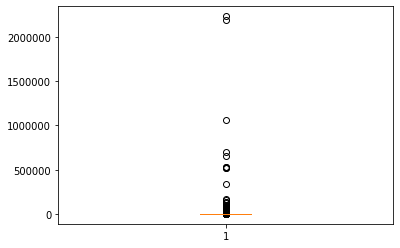

In [173]:
plt.boxplot(event_df['start_to_end'])

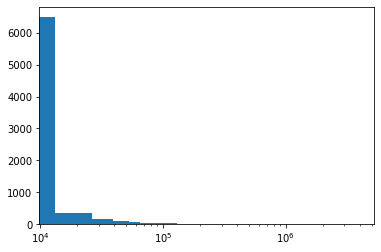

In [174]:
plt.hist(event_df.created_to_publish,bins=300)
plt.xscale('log')

In [175]:
times = event_df.created_dt.dt.hour

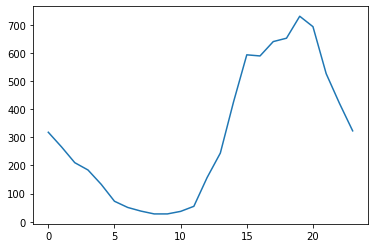

In [176]:
plt.plot(times.value_counts().sort_index())

In [177]:
event_df.columns

Index(['category_id', 'cost_0', 'country', 'created_dt', 'currency',
       'donation_0', 'end_local_dt', 'fee_0', 'format_id', 'free_0',
       'has_available_tickets', 'id', 'include_fee_0', 'inventory_type',
       'is_paid', 'is_reserved_seating', 'is_sold_out', 'locale',
       'on_sale_status_0', 'online_event', 'published_dt', 'refund_policy',
       'region', 'shareable', 'start_local_dt', 'start_tz', 'subcategory_id',
       'tax_0', 'venue_id', 'waitlist_available', 'created_to_publish',
       'publish_to_start', 'start_to_end'],
      dtype='object')

In [178]:
from sklearn.preprocessing import OneHotEncoder

"""Make a copy of the dataframe which will be our final transformation
before building a model."""
train = event_df.copy()

# Create instance of OHE
ohe_enc = OneHotEncoder(sparse=False,categories='auto')

# Features to OHE
feature_list = categorical_cols

# Fit the one hot encoder
cat_features_ohe = ohe_enc.fit_transform(train[feature_list])

# One hot encode each feature
k=0
for feature in range(len(ohe_enc.categories_)):
    
    for cat in ohe_enc.categories_[feature]:
    
        """Do not create new OHE column for last category of each feature
        It will be redundant information and is not needed."""
        if cat != ohe_enc.categories_[feature][-1]:
            train['_'.join((feature_list[feature],str(cat)))] = cat_features_ohe[:,k]
            
        k+=1

# Drop old feature columns
train.drop(labels=feature_list,axis=1,inplace=True)

# Check the head of the dataframe
train.head()

,cost_0,created_dt,end_local_dt,fee_0,id,published_dt,start_local_dt,tax_0,venue_id,created_to_publish,...,subcategory_id_14001.0,subcategory_id_15001.0,subcategory_id_15005.0,subcategory_id_16004.0,subcategory_id_16005.0,subcategory_id_16006.0,subcategory_id_17003.0,subcategory_id_18001.0,subcategory_id_19008.0,waitlist_available_0.0
0,30.0,2018-06-07 13:32:09,2018-09-03 17:00:00,3.72,46844131057,2018-06-07 13:43:31,2018-09-03 09:00:00,0.0,25149064.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,15.0,2018-07-28 19:47:56,2018-09-01 12:00:00,0.00,48522658578,2018-07-28 19:49:52,2018-09-01 11:00:00,0.0,20307481.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,135.0,2018-06-28 20:37:37,2018-09-01 21:00:00,0.00,47569506675,2018-06-28 20:37:40,2018-09-01 18:00:00,0.0,24881752.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,20.0,2018-06-22 11:57:43,2018-09-01 12:00:00,1.19,47349009161,2018-06-22 11:58:27,2018-09-01 09:30:00,0.0,22394135.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,18.0,2018-08-05 23:27:51,2018-09-01 23:00:00,0.00,48782412509,2018-08-05 23:28:57,2018-09-01 21:30:00,0.0,22687889.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [181]:
train.describe()

,cost_0,fee_0,id,tax_0,venue_id,created_to_publish,publish_to_start,start_to_end,category_id_-999.0,category_id_101.0,...,subcategory_id_14001.0,subcategory_id_15001.0,subcategory_id_15005.0,subcategory_id_16004.0,subcategory_id_16005.0,subcategory_id_16006.0,subcategory_id_17003.0,subcategory_id_18001.0,subcategory_id_19008.0,waitlist_available_0.0
count,7415.000000,7415.000000,7.415000e+03,7415.000000,7.415000e+03,7.415000e+03,7.415000e+03,7.415000e+03,7415.000000,7415.000000,...,7415.000000,7415.000000,7415.000000,7415.000000,7415.000000,7415.000000,7415.000000,7415.000000,7415.000000,7415.000000
mean,202.794422,4.322053,4.858880e+10,0.250673,2.325898e+07,1.247311e+04,1.111646e+05,2.158475e+03,0.084963,0.157114,...,0.015509,0.018476,0.008631,0.007552,0.002832,0.007283,0.004990,0.005664,0.004720,0.914363
std,2269.860628,35.795749,3.326126e+09,3.056419,5.509786e+06,1.049435e+05,1.131222e+05,4.227504e+04,0.278845,0.363933,...,0.123574,0.134674,0.092508,0.086581,0.053146,0.085032,0.070467,0.075052,0.068546,0.279846
min,0.000000,0.000000,1.418538e+09,0.000000,-9.990000e+02,0.000000e+00,-1.301700e+04,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,4.771583e+10,0.000000,2.113853e+07,1.000000e+00,4.284550e+04,1.500000e+02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,25.000000,2.030000,4.919671e+10,0.000000,2.564812e+07,1.200000e+01,7.508400e+04,2.400000e+02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,60.000000,3.720000,5.043556e+10,0.000000,2.666199e+07,2.565000e+03,1.334800e+05,3.600000e+02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,100000.000000,1525.700000,7.098003e+10,138.550000,3.869983e+07,3.930021e+06,2.172171e+06,2.233620e+06,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [184]:
pd.options.display.max_rows = 500
train.mean()

cost_0                                   2.027944e+02
fee_0                                    4.322053e+00
id                                       4.858880e+10
tax_0                                    2.506730e-01
venue_id                                 2.325898e+07
created_to_publish                       1.247311e+04
publish_to_start                         1.111646e+05
start_to_end                             2.158475e+03
category_id_-999.0                       8.496291e-02
category_id_101.0                        1.571140e-01
category_id_102.0                        3.182738e-02
category_id_103.0                        1.301416e-01
category_id_104.0                        2.683749e-02
category_id_105.0                        5.677680e-02
category_id_106.0                        2.063385e-02
category_id_107.0                        5.124747e-02
category_id_108.0                        1.496966e-02
category_id_109.0                        1.753203e-03
category_id_110.0           

In [185]:
train.shape

(7415, 208)

In [186]:
train.to_csv('./event_df_cleaned.csv',index_label='index')